# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://dc-edu.itmo.ru/assets/courseware/v1/8baa546c1c38f02f9ef2c11333112e89/asset-v1:ITMO+DA+2023+type@asset+block/titanic_train.csv')
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


Установите количество пропущенных значений поля <code>age</code>:

In [ ]:
print(df.isnull().sum())
print('\nЧисло пропущенных значений поля age: ', df.isnull().sum()['age'])

pclass         0
survived       0
name           0
sex            0
age          199
sibsp          0
parch          0
ticket         0
fare           0
cabin        769
embarked       0
home.dest    414
dtype: int64

Число пропущенных значений поля age:  199


Определите долю выживших

In [ ]:
df['survived'].mean()

0.382262996941896

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [ ]:
print(df.isnull().sum()/len(df))
columns_to_drop = ['cabin', 'home.dest', 'ticket']
df_droped = df.drop(columns_to_drop, axis=1)
df_droped.head(2)

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.202854
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
cabin        0.783894
embarked     0.000000
home.dest    0.422018
dtype: float64


,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [ ]:
df_droped['fam_size'] = df_droped['sibsp'] + df_droped['parch']
df_droped = df_droped.drop(columns=['sibsp', 'parch'])
print('\nФинальное число признаков: ', df_droped.shape[1]-1)
print('Среднее колонки fam_size', df_droped['fam_size'].mean())
df_droped


Финальное число признаков:  7
Среднее колонки fam_size 0.8664627930682977


,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания) Введите полученное число предикторов.

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [ ]:
from itertools import product
classes = [1,2,3]
gender = ['female', 'male']
prob_to_survive = {}
for cl, gn in product(classes, gender):
  prob_to_survive['{} & pclass:{}'.format(gn,cl)] = len(df[(df['pclass']==cl) & (df['sex']==gn) & df['survived']==1])/len(df[(df['pclass']==cl) & (df['sex']==gn)])
prob_to_survive

{'female & pclass:1': 0.9711538461538461,
 'male & pclass:1': 0.33088235294117646,
 'female & pclass:2': 0.8461538461538461,
 'male & pclass:2': 0.15503875968992248,
 'female & pclass:3': 0.5030674846625767,
 'male & pclass:3': 0.16442048517520216}

Постройте гистограммы выжиших и невыживших по возрастам. Укажите номер гистограммы, соответствующей распределению возрастов выживших

<Axes: xlabel='age', ylabel='Count'>

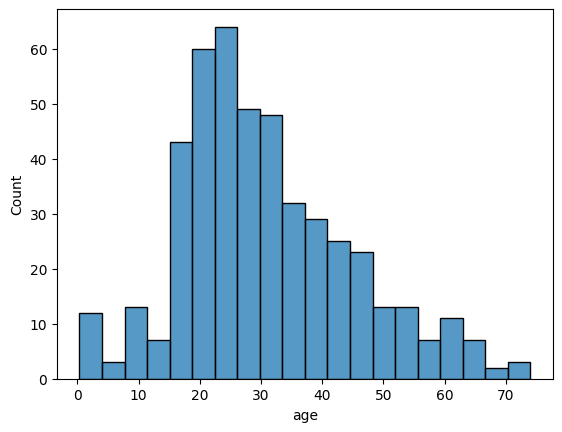

In [ ]:
sns.histplot(data=df_droped[df_droped['survived']==0], x='age', bins=20)

<Axes: xlabel='age', ylabel='Count'>

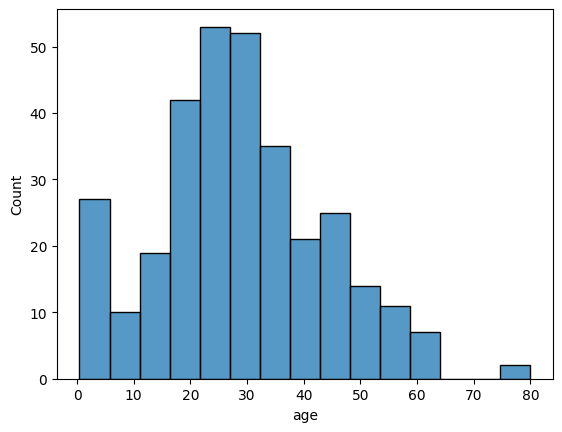

In [ ]:
sns.histplot(data=df_droped[df_droped['survived']==1], x='age', bins=15)

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



Определение категориальных и не категориальных признаков
python
Copy
cat_features = ['name', 'sex', 'embarked']
non_cat_features = list(set(df_droped.columns).difference(set(cat_features)))
cat_features — это список, содержащий имена категориальных признаков (столбцов) в датафрейме df_droped. В данном случае это 'name', 'sex' и 'embarked'.

non_cat_features — это список, содержащий имена всех остальных признаков (столбцов) в датафрейме df_droped, которые не являются категориальными. Это делается с помощью операции difference между множеством всех столбцов и множеством категориальных столбцов.

2. Удаление строк с пропущенными значениями и построение модели
python
Copy
score, report = build_model(df_droped[non_cat_features].dropna())
df_droped[non_cat_features] — это подмножество датафрейма df_droped, содержащее только не категориальные признаки.

.dropna() — это метод, который удаляет все строки, содержащие хотя бы одно пропущенное значение (NaN) в любом из столбцов.

build_model(...) — это функция, которая принимает очищенный датафрейм (без пропущенных значений) и возвращает два значения: score и report. Предположительно, score — это метрика качества модели (например, F1-score), а report — это отчет о производительности модели (например, classification report).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random_state = 13


def build_model(df):
  X, y = df.drop('survived', axis=1), df['survived']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
  lr = LogisticRegression(random_state=random_state, max_iter=1000).fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  f_1_score = f1_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, digits = 3)
  return f_1_score, report, y_pred

cat_features = ['name', 'sex', 'embarked']
non_cat_features = list(set(df_droped.columns).difference(set(cat_features)))
score, report, y_pred = build_model(df_droped[non_cat_features].dropna())
print('f1_score_drop_na', score)

f1_score_drop_na 0.4423076923076923


In [ ]:
print(report)

              precision    recall  f1-score   support

           0      0.650     0.817     0.724        93
           1      0.575     0.359     0.442        64

    accuracy                          0.631       157
   macro avg      0.612     0.588     0.583       157
weighted avg      0.619     0.631     0.609       157



In [ ]:
print('y_pred',y_pred)

y_pred [0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0
 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 1 0 1 1 0]


## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
from sklearn.impute import SimpleImputer
df_imputed_by_mean = df_droped[non_cat_features].fillna(df_droped[non_cat_features].mean()['age'])
score, report,y_pred = build_model(df_imputed_by_mean)
print('f1_score_imputed_by_mean', score)

f1_score_imputed_by_mean 0.4482758620689655


## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [ ]:
df_droped['honorific'] = list(df_droped['name'].str.extract('([A-Za-z]+)\.')[0])
pd.crosstab(df_droped['sex'],df_droped['honorific']).style.background_gradient()

honorific,Capt,Col,Countess,Don,Dona,Dr,Major,Master,Miss,Mlle,Mr,Mrs,Ms,Rev
sex,,,,,,,,,,,,,,
female,0,0,1,0,1,0,0,0,194,2,0,145,2,0
male,1,3,0,1,0,6,1,46,0,0,572,0,0,6


In [ ]:
print('Число уникальных honorific: ', len(df_droped['honorific'].unique()))
df_droped['honorific'].unique()

Число уникальных honorific:  14


array(['Miss', 'Mrs', 'Mr', 'Master', 'Mlle', 'Rev', 'Ms', 'Col', 'Dona',
       'Dr', 'Countess', 'Major', 'Don', 'Capt'], dtype=object)

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [ ]:
df_droped['honorific'].\
replace(['Mlle', 'Rev', 'Ms' ,  'Col', 'Dona', 'Dr', 'Countess', 'Major', 'Don', 'Capt'],\
        ['Miss', 'Mr' , 'Miss', 'Mr' ,  'Mrs' ,  'Mr',    'Mrs'  ,  'Mr',  'Mr',  'Mr' ], inplace=True)
pd.crosstab(df_droped['sex'],df_droped['honorific']).style.background_gradient()

<ipython-input-108-5dfb057fe531>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_droped['honorific'].\


honorific,Master,Miss,Mr,Mrs
sex,,,,
female,0,198,0,147
male,46,0,590,0


Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [ ]:
print('Master_rate', len(df_droped[df_droped['honorific']=='Master'])/len(df_droped[df_droped['sex']=='male']))

Master_rate 0.07232704402515723


Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [ ]:
dict(df_droped.groupby('honorific')['age'].mean())

{'Master': 5.128205128205129,
 'Miss': 22.005765408805033,
 'Mr': 32.90043763676149,
 'Mrs': 36.98425196850393}

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

In [ ]:
df_droped.loc[(df_droped['age'].isnull()) & (df_droped['honorific'] == 'Master'), 'age'] = dict(df_droped.groupby('honorific')['age'].mean())['Master']
df_droped.loc[(df_droped['age'].isnull()) & (df_droped['honorific'] == 'Miss'), 'age'] = dict(df_droped.groupby('honorific')['age'].mean())['Miss']
df_droped.loc[(df_droped['age'].isnull()) & (df_droped['honorific'] == 'Mr'), 'age'] = dict(df_droped.groupby('honorific')['age'].mean())['Mr']
df_droped.loc[(df_droped['age'].isnull()) & (df_droped['honorific'] == 'Mrs'), 'age'] = dict(df_droped.groupby('honorific')['age'].mean())['Mrs']
print(df_droped.isnull().sum())

pclass       0
survived     0
name         0
sex          0
age          0
fare         0
embarked     0
fam_size     0
honorific    0
dtype: int64


In [ ]:
df_imputed_by_honorific = df_droped.drop(columns=cat_features+['honorific'])
score, report, y_pred = build_model(df_imputed_by_honorific)
print('f1_score_imputed_by_honorific', score)

f1_score_imputed_by_honorific 0.4745762711864407


# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [ ]:
df_droped_one_hot = df_droped.drop(columns=['name', 'honorific'])
df_droped_one_hot = pd.get_dummies(df_droped_one_hot, drop_first=True)
score, report, y_pred = build_model(df_droped_one_hot)
print('f1_score_df_droped_one_hot', score)

f1_score_df_droped_one_hot 0.7567567567567568


In [ ]:
print(report)

              precision    recall  f1-score   support

           0      0.847     0.861     0.854       122
           1      0.767     0.747     0.757        75

    accuracy                          0.817       197
   macro avg      0.807     0.804     0.805       197
weighted avg      0.816     0.817     0.817       197



In [ ]:
df_droped_one_hot.head()

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,1,22.005765,7.7333,0,False,True,False
1,3,1,22.005765,7.7500,0,False,True,False
2,3,1,38.000000,7.2292,0,False,False,False
3,3,0,22.000000,7.8958,0,True,False,True
4,3,0,16.000000,9.5000,0,True,False,True


**Попробуем теперь протестировать наши данные сделав стандартизацию. Поэксперементируем.**

**Стандартизация с использованием MinMaxScaler:**


scaler = MinMaxScaler(): Создаем экземпляр MinMaxScaler.

df_droped_one_hot_scaled = pd.DataFrame(scaler.fit_transform(df_droped_one_hot), columns=df_droped_one_hot.columns): Применяем стандартизацию и создаем новый датафрейм с теми же столбцами.

Построение модели и вычисление метрик после стандартизации:

score_scaled, report_scaled = build_model(df_droped_one_hot_scaled): Строим модель на стандартизированных данных и получаем метрики.

print('f1_score_df_droped_one_hot_scaled', score_scaled): Выводим F1-score после стандартизации.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Стандартизация с использованием MinMaxScaler
scaler = MinMaxScaler()
df_droped_one_hot_scaled = pd.DataFrame(scaler.fit_transform(df_droped_one_hot), columns=df_droped_one_hot.columns)

# Построение модели и вычисление метрик после стандартизации
score_scaled, report_scaled, y_pred = build_model(df_droped_one_hot_scaled)
print('f1_score_df_droped_one_hot_scaled', score_scaled)

f1_score_df_droped_one_hot_scaled 0.7417218543046358


 ПОЧЕМУ СНИЗИЛАСЬ ОШИБКА !

Возможные причины уменьшения ошибки после стандартизации:
Устранение влияния масштаба:

Стандартизация (например, с использованием MinMaxScaler) приводит к тому, что все признаки имеют одинаковый масштаб (обычно от 0 до 1). Это может помочь моделям, чувствительным к масштабу признаков (например, линейные модели, SVM, нейронные сети), лучше обучаться и давать более точные предсказания.

Улучшение сходимости алгоритмов:

Для алгоритмов, использующих градиентный спуск (например, линейная регрессия, логистическая регрессия), стандартизация может улучшить сходимость, что приводит к более быстрому и стабильному обучению.

Уменьшение влияния выбросов:

Стандартизация может уменьшить влияние выбросов, так как она сжимает значения в определенном диапазоне. Это может привести к более устойчивым результатам.

Возможные причины увеличения ошибки после стандартизации:
Потеря информации:

Стандартизация может привести к потере некоторой информации, особенно если данные имеют сильно нелинейные зависимости. Например, если в данных есть несколько выбросов, стандартизация может сжать значения, что может негативно сказаться на производительности модели.

Неподходящий алгоритм:

Не все модели чувствительны к масштабу признаков. Например, деревья решений и случайный лес не зависят от масштаба признаков, поэтому стандартизация может не привести к улучшению производительности.

Неправильная настройка параметров:

Если параметры стандартизации (например, диапазон для MinMaxScaler) настроены неправильно, это может привести к ухудшению производительности модели.

Как определить причину:
Анализ данных:

Проанализируем данные до и после стандартизации. Посмотрите на распределения признаков и наличие выбросов.

Сравнение моделей:

Попробуем обучить несколько моделей (например, линейная регрессия, дерево решений, случайный лес) до и после стандартизации. Сравните их производительность.

Изменение параметров стандартизации:

Попробуем изменить параметры стандартизации (например, использовать другой диапазон для MinMaxScaler) и посмотреть, как это повлияет на результаты.

Использование других методов нормализации:

Попробуем другие методы нормализации, такие как StandardScaler (стандартизация к среднему 0 и дисперсии 1) или RobustScaler (менее чувствительный к выбросам).

ВЕСЬ КОД ПРЕДЫДУЩИЙ В ОДНОМ :

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# Устанавливаем random_state
random_state = 13

# Функция для построения модели и вычисления F1-score
def build_model(df):
    X, y = df.drop('survived', axis=1), df['survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    lr = LogisticRegression(random_state=random_state, max_iter=1000).fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    f_1_score = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=3)
    return f_1_score, report

# One-hot кодирование
df_droped_one_hot = df_droped.drop(columns=['name', 'honorific'])
df_droped_one_hot = pd.get_dummies(df_droped_one_hot, drop_first=True)

# Строим модель и вычисляем метрики после one-hot кодирования
score_one_hot, report_one_hot = build_model(df_droped_one_hot)
print('f1_score_df_droped_one_hot', score_one_hot)

# Применяем MinMaxScaler к данным после one-hot кодирования
scaler = MinMaxScaler()
df_droped_one_hot_scaled = pd.DataFrame(scaler.fit_transform(df_droped_one_hot.drop('survived', axis=1)), columns=df_droped_one_hot.drop('survived', axis=1).columns)
df_droped_one_hot_scaled['survived'] = df_droped_one_hot['survived']

# Строим модель и вычисляем метрики после стандартизации
score_scaled, report_scaled = build_model(df_droped_one_hot_scaled)
print('f1_score_df_droped_one_hot_scaled', score_scaled)

f1_score_df_droped_one_hot 0.7567567567567568
f1_score_df_droped_one_hot_scaled 0.7417218543046358


ПОСМОТРИМ НА ДРУГИЕ МЕТОДЫ И СРАВНИМ

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# Устанавливаем random_state
random_state = 13

# Функция для построения модели и вычисления F1-score
def build_model(df):
    X, y = df.drop('survived', axis=1), df['survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    lr = LogisticRegression(random_state=random_state, max_iter=1000).fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    f_1_score = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=3)
    return f_1_score, report

# One-hot кодирование
df_droped_one_hot = df_droped.drop(columns=['name', 'honorific'])
df_droped_one_hot = pd.get_dummies(df_droped_one_hot, drop_first=True)

# Строим модель и вычисляем метрики после one-hot кодирования
score_one_hot, report_one_hot = build_model(df_droped_one_hot)
print('f1_score_df_droped_one_hot', score_one_hot)

# Применяем MinMaxScaler к данным после one-hot кодирования
scaler_minmax = MinMaxScaler()
df_droped_one_hot_minmax = pd.DataFrame(scaler_minmax.fit_transform(df_droped_one_hot.drop('survived', axis=1)), columns=df_droped_one_hot.drop('survived', axis=1).columns)
df_droped_one_hot_minmax['survived'] = df_droped_one_hot['survived']

# Строим модель и вычисляем метрики после MinMaxScaler
score_minmax, report_minmax = build_model(df_droped_one_hot_minmax)
print('f1_score_df_droped_one_hot_minmax', score_minmax)

# Применяем StandardScaler к данным после one-hot кодирования
scaler_standard = StandardScaler()
df_droped_one_hot_standard = pd.DataFrame(scaler_standard.fit_transform(df_droped_one_hot.drop('survived', axis=1)), columns=df_droped_one_hot.drop('survived', axis=1).columns)
df_droped_one_hot_standard['survived'] = df_droped_one_hot['survived']

# Строим модель и вычисляем метрики после StandardScaler
score_standard, report_standard = build_model(df_droped_one_hot_standard)
print('f1_score_df_droped_one_hot_standard', score_standard)

# Применяем RobustScaler к данным после one-hot кодирования
scaler_robust = RobustScaler()
df_droped_one_hot_robust = pd.DataFrame(scaler_robust.fit_transform(df_droped_one_hot.drop('survived', axis=1)), columns=df_droped_one_hot.drop('survived', axis=1).columns)
df_droped_one_hot_robust['survived'] = df_droped_one_hot['survived']

# Строим модель и вычисляем метрики после RobustScaler
score_robust, report_robust = build_model(df_droped_one_hot_robust)
print('f1_score_df_droped_one_hot_robust', score_robust)

f1_score_df_droped_one_hot 0.7567567567567568
f1_score_df_droped_one_hot_minmax 0.7417218543046358
f1_score_df_droped_one_hot_standard 0.7516778523489933
f1_score_df_droped_one_hot_robust 0.7567567567567568


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# Устанавливаем random_state
random_state = 13

# Функция для построения модели и вычисления F1-score
def build_model(df):
    X, y = df.drop('survived', axis=1), df['survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    lr = LogisticRegression(random_state=random_state, max_iter=1000).fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    f_1_score = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=3)
    return f_1_score, report, y_pred

# One-hot кодирование
df_droped_one_hot = df_droped.drop(columns=['name', 'honorific'])
df_droped_one_hot = pd.get_dummies(df_droped_one_hot, drop_first=True)

# Строим модель и вычисляем метрики после one-hot кодирования
score_one_hot, report_one_hot, y_pred_one_hot = build_model(df_droped_one_hot)
print('f1_score_df_droped_one_hot', score_one_hot)

# Применяем MinMaxScaler к данным после one-hot кодирования
scaler_minmax = MinMaxScaler()
df_droped_one_hot_minmax = pd.DataFrame(scaler_minmax.fit_transform(df_droped_one_hot.drop('survived', axis=1)), columns=df_droped_one_hot.drop('survived', axis=1).columns)
df_droped_one_hot_minmax['survived'] = df_droped_one_hot['survived']

# Строим модель и вычисляем метрики после MinMaxScaler
score_minmax, report_minmax, y_pred_minmax = build_model(df_droped_one_hot_minmax)
print('f1_score_df_droped_one_hot_minmax', score_minmax)

# Применяем StandardScaler к данным после one-hot кодирования
scaler_standard = StandardScaler()
df_droped_one_hot_standard = pd.DataFrame(scaler_standard.fit_transform(df_droped_one_hot.drop('survived', axis=1)), columns=df_droped_one_hot.drop('survived', axis=1).columns)
df_droped_one_hot_standard['survived'] = df_droped_one_hot['survived']

# Строим модель и вычисляем метрики после StandardScaler
score_standard, report_standard, y_pred_standard = build_model(df_droped_one_hot_standard)
print('f1_score_df_droped_one_hot_standard', score_standard)

# Применяем RobustScaler к данным после one-hot кодирования
scaler_robust = RobustScaler()
df_droped_one_hot_robust = pd.DataFrame(scaler_robust.fit_transform(df_droped_one_hot.drop('survived', axis=1)), columns=df_droped_one_hot.drop('survived', axis=1).columns)
df_droped_one_hot_robust['survived'] = df_droped_one_hot['survived']

# Строим модель и вычисляем метрики после RobustScaler
score_robust, report_robust, y_pred_robust = build_model(df_droped_one_hot_robust)
print('f1_score_df_droped_one_hot_robust', score_robust)

# Выводим предсказанные значения для каждого метода нормализации
print("Predictions after one-hot encoding:", y_pred_one_hot)
print("Predictions after MinMaxScaler:", y_pred_minmax)
print("Predictions after StandardScaler:", y_pred_standard)
print("Predictions after RobustScaler:", y_pred_robust)

f1_score_df_droped_one_hot 0.7567567567567568
f1_score_df_droped_one_hot_minmax 0.7417218543046358
f1_score_df_droped_one_hot_standard 0.7516778523489933
f1_score_df_droped_one_hot_robust 0.7567567567567568
Predictions after one-hot encoding: [1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0
 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1
 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1
 0 0 0 0 0 0 1 0 1 0 0 0]
Predictions after MinMaxScaler: [1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0
 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1
 1 0 0 0 0 1 1 0 1 0 1 1

In [ ]:
print("Predictions after one-hot encoding:", y_pred_one_hot.mean())
print("Predictions after MinMaxScaler:", y_pred_minmax.mean())             # лучше всех определил предикт, так как выше видно сколько 0 и 1 у нас
print("Predictions after StandardScaler:", y_pred_standard.mean())
print("Predictions after RobustScaler:", y_pred_robust.mean())

Predictions after one-hot encoding: 0.37055837563451777
Predictions after MinMaxScaler: 0.38578680203045684
Predictions after StandardScaler: 0.3756345177664975
Predictions after RobustScaler: 0.37055837563451777
